# Depth Normalization

In this notebook, we will explore the CreStereo Depth maps and learn how to prepare them for deep learning

In [1]:
import os

import numpy as np
import cv2

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from dataloader import CityScapesDataset
from transformations import *

In [10]:
from dataloader import CityScapesDataset

root = "C:/Users/itber/Documents/datasets/cityscapes"
BATCH_SIZE = 64

train_dataset = CityScapesDataset(root, transform=None, split='train', label_map='trainId') # 'trainId')
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=False) # set Shuffle to True

In [11]:
sample = next(iter(train_loader))

In [54]:
_, _, depth = sample['left'], sample['mask'], sample['depth']

In [55]:
depth = depth.numpy()
depth.shape

(64, 800, 2048)

Compute basic sstatistics (need to convert to float32 to avoid overflow in std dev computation)

In [56]:
depth.min(), depth.max(), depth.mean(), depth.astype(np.float32).std()

(3.97, 4736.0, 38.84, 43.396816)

Now let's inspect the distribution

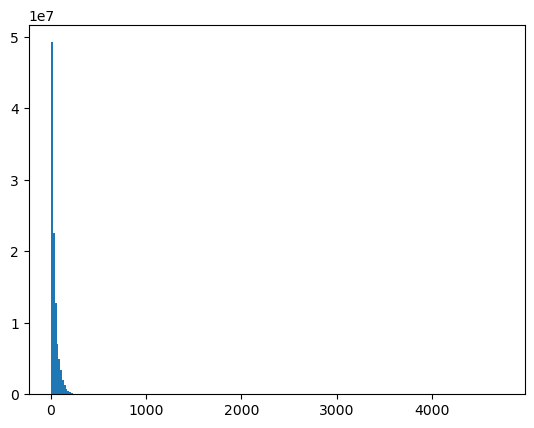

In [57]:
plt.hist(depth.flatten(), bins=250);

We can see that most of the values are less than 500 meters, let's zoom in to see exactly where the majority of the data lays.

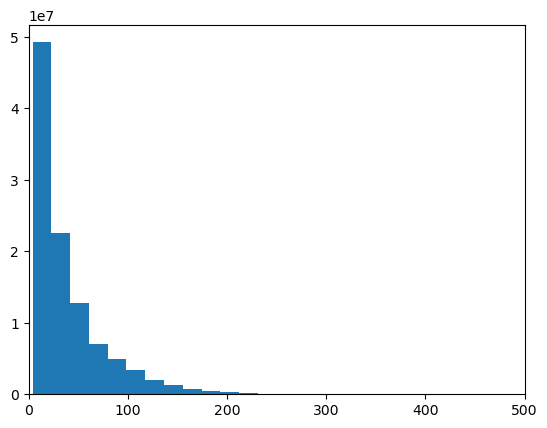

In [59]:
plt.hist(depth.flatten(), bins=250);
plt.xlim(0, 500);

We can now see that the data becomes very sparse after 250 meters. We will clip the depth parameters to 250 ft max. Stereo depth is usually inaccuarate for far away objects, and therefore unreleiable for large distances. So after a certain distance, we really don't care how far away the objects are as long as we know that they are far away.

In this case we are using a subset fo the training data to find out where to clip the parameters. We could do this arbitrarily, and clip them to say 100 meters, but this could lead to a more oddly distributed training distribution which could hinder training. Clipping the depth to 250 will produce a cut off artifact in the distribution. The cut off artifact corresponds to a mode present at the clip point, which usually indicates that the data is actually spread out further.

Another approach would be to discretely categorize depths into a fixed number of distances. Even though that may be easier to learn, we will avoid that approach for now in favor of depth regression.

In [60]:
depth = np.clip(depth, 0, 250)

depth.min(), depth.max(), depth.mean(), depth.astype(np.float32).std()

(3.97, 250.0, 38.56, 37.157917)

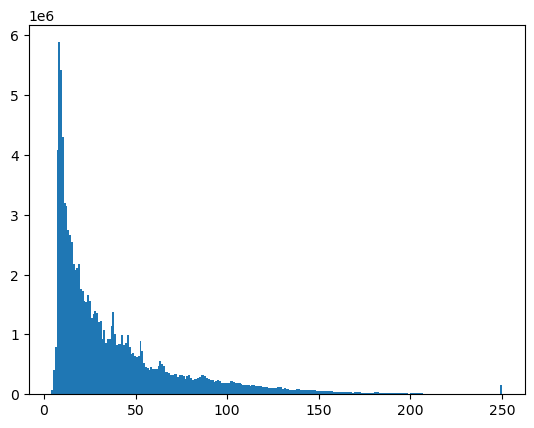

In [61]:
plt.hist(depth.flatten(), bins=250);

We can see a sharp peak roughly around 10ft, and we have a mode around 250, which corresponds to the clipping artifact that we have introduced.

Now we will attempt to transform the data to make more Normal, first we will take the log of the distribution and then divide it by a normalizing factor. Since we have clipped that data to be 250 max, we will divide it by ~log(250)

In [62]:
np.log(250)

5.521460917862246

In [64]:
transformed_depth = np.log(depth.flatten())/5

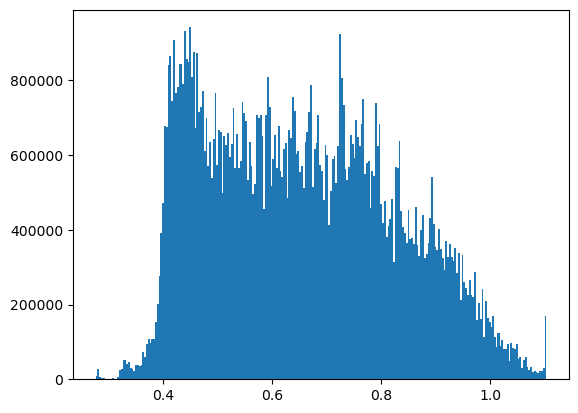

In [65]:
plt.hist(transformed_depth, bins=250);

Now we have more well behaved depth distribution. We still have the cut-off artifact at the far right, and we need to keep this in mind to determine how it may drive depth predictions.

So the overall transformation pipeline for raw depth inputs is:
- clip to 0-250
- natural log of clipped depth
- divide by 5


To obtain the predicted depth from a model output, we simply reverse the transformation
- multiply by 5
- exponential of output

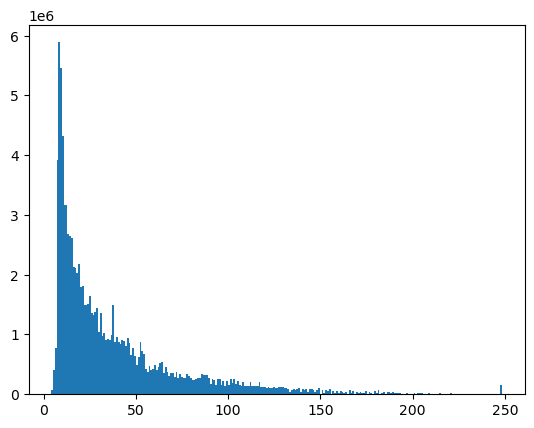

In [68]:
plt.hist(np.exp(transformed_depth*5), bins=250);